In [9]:
import baltic as bt
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
import json
import seaborn as sns
from collections import defaultdict
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap


In [2]:
json_key = {'name': 'strain', 'height': 'xvalue'}
titer_tree = bt.loadJSON('/Users/Sidney/nextstrain/augur/builds/dengue/auspice/dengue_all_tree.json', json_key)



Tree height: 0.357550
Tree length: 6.132190
annotations present

Numbers of objects in tree: 2998 (1428 nodes and 1570 leaves)



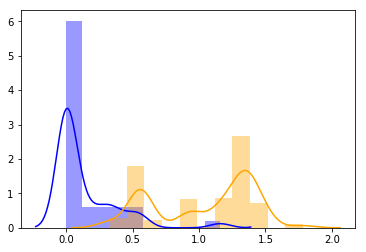

In [12]:
dTiter_vals = [n.traits['dTiter'] for n in titer_tree.nodes if n.traits['dTiter'] > 0]
cTiter_vals = [n.traits['cTiter'] for n in titer_tree.nodes if n.traits['cTiter'] > 0]

ax = sns.distplot(dTiter_vals, color='blue')
ax = sns.distplot(cTiter_vals, color='orange')

In [41]:
def get_antigenic_mutations(tree, cutoff):
    dTiter_records = []
    dTiter_branches = [n for n in titer_tree.nodes if n.traits['dTiter'] >= cutoff]
    
    def within_serotype(branch):
        descendent_serotypes = [l.split('/')[0] for l in branch.leaves if not l.startswith('DENV/')] ## Why are there so many DENV seqs?
        return len(set(descendent_serotypes)) == 1

    def parse_mutations(gene, mut, branch_record):
        mut_record = branch_record.copy()
        mut_record['gene'] = gene
        mut_record['site'] = int(mut[1:-1])
        mut_record['allele0'] = mut[0]
        mut_record['allele1'] = mut[-1]
        return mut_record
    
    for branch in dTiter_branches:
        branch_record = {
            'dTiter': float(branch.traits['dTiter']),
            'branch_id': branch.traits['clade'],
            'leaves': branch.leaves,
        }
        
        
        if within_serotype(branch) and within_serotype(branch.parent):
            branch_record['serotype'] = [l.split('/')[0] for l in branch.leaves if not l.startswith('DENV/')][0]
        else:
            branch_record['serotype'] = np.nan
        
        E_muts = branch.traits['aa_muts']['E']
        M_muts = branch.traits['aa_muts']['M']
        
        for E_mut in E_muts:
            dTiter_records.append(parse_mutations('E', E_mut, branch_record))
        for M_mut in M_muts:
            dTiter_records.append(parse_mutations('M', M_mut, branch_record))
            
    return pd.DataFrame(dTiter_records)

In [42]:
antigenic_mutations = get_antigenic_mutations(titer_tree, 0.15)
E_antigenic_mutations = antigenic_mutations.loc[antigenic_mutations['gene'] == 'E']

intraserotype_antigenic_mutations = antigenic_mutations.loc[~antigenic_mutations['serotype'].isnull()]
E_intraserotype_antigenic_mutations = intraserotype_antigenic_mutations.loc[intraserotype_antigenic_mutations['gene'] == 'E']

In [122]:
#### Why are the dTiter values behaving suspiciously like cTiter....??

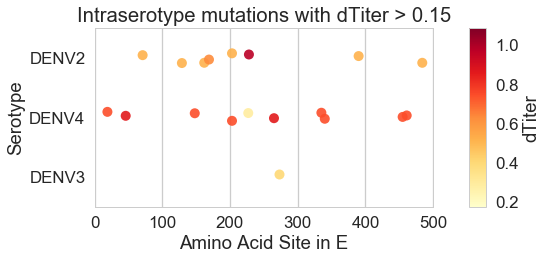

In [57]:
sns.set(style='whitegrid', context='talk', font_scale=1.3)
fig, axes = plt.subplots(1,2, figsize=(8,4), gridspec_kw={'width_ratios': [20,1]})
sns.stripplot(x='site', y='serotype', hue='dTiter', 
              data=E_intraserotype_antigenic_mutations, 
              orient='h', palette="YlOrRd", ax=axes[0], s=10, 
              alpha=0.9, jitter=True)

axes[0].legend_.remove()

cmap = ListedColormap(sns.color_palette('YlOrRd', n_colors=256))
norm = mpl.colors.Normalize(vmin=E_intraserotype_antigenic_mutations['dTiter'].min(), 
                            vmax=E_intraserotype_antigenic_mutations['dTiter'].max())
cb1 = mpl.colorbar.ColorbarBase(axes[1], cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('dTiter')

axes[0].set_xlim(0, 500)
axes[0].set_title('Intraserotype mutations with dTiter > 0.15')
axes[0].set_xlabel('Amino Acid Site in E')
axes[0].set_ylabel('Serotype')

plt.tight_layout()
plt.savefig('/Users/Sidney/Desktop/antigenic_muts.png', dpi=400)


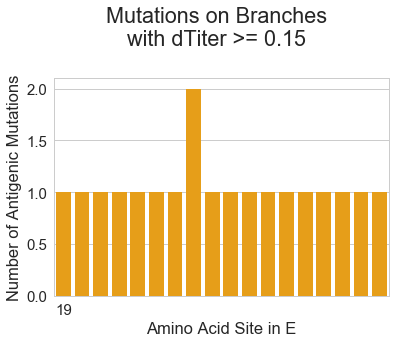

In [48]:
ax = sns.countplot(E_intraserotype_antigenic_mutations['site'], color='orange', saturation=0.8)
for idx,label in enumerate(ax.xaxis.get_ticklabels()):
    if idx%50 != 0:
        label.set_visible(False)
ax.set_xlabel('Amino Acid Site in E')
ax.set_ylabel('Number of Antigenic Mutations')
plt.suptitle('Mutations on Branches\nwith dTiter >= 0.15', va='bottom')